<a href="https://colab.research.google.com/github/maxmatical/Machine-Learning/blob/master/Yamana_Case_Max.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Given csv, we want to predict columns S/T/U/Y (aurec/agrec/nacnc/codt)

- aurec: gold recovery rate (0-1)
- agrec: silver recovery rate (0-1)
- nacnc: amont of cyanide used
- codt: classification

-99 is a value that's below detection limit, NOT the same as 0

<0.1 or whatever in data

geocod (rock type) and bound are categorical

installing fastai library

In [0]:
# Set up environment and download course-v3
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai
!pip install fastprogress
!pip install pathlib

!curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
from fastai import *
from fastai.tabular import *


In [0]:
import pandas as pd
import matplotlib as plt
import numpy as np

load csv to /content/data

In [0]:
path = '/content/data/'
os.makedirs(path, exist_ok=True)
fname = 'yamana'
#path

In [0]:
df = pd.read_csv(f'{path}{fname}.csv', low_memory=False)

In [0]:
df.head(20)

In [0]:
df['aurec'].dtype

dtype('float64')

In [0]:
#df['aurec']=df['aurec'].replace(0.9,27, inplace =False)

First just try using columns C to P as covariates 

In [0]:

?? FillMissing

In [0]:
cat_names = ['geocod', 'bound']
cont_names = ['midx', 'midy', 'midz', 'topx', 'topy', 'topz', 'botx', 'boty', 'botz',
             'length', 'from', 'to']
dep_var = 'codt'



In [0]:
# defining procs (without fillmissing)
procs = [Categorify, Normalize]

## predicting codt class

### Deep learning

In [0]:
bs = 256


data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .random_split_by_pct(0.2)#split by percent 
                   .label_from_df(cols='codt')
                   .databunch(bs = bs))

In [0]:
learn = tabular_learner(data, layers = [1000,500], emb_drop = 0.05, metrics = [accuracy], ps = [0.5, 0.5])


In [0]:
learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


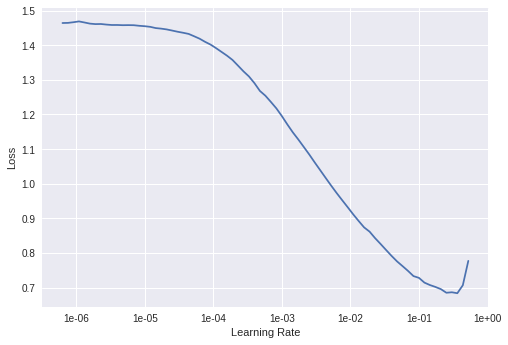

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
learn.save('stage-0-codt')

In [0]:
learn.load('stage-0-codt')

Learner(data=TabularDataBunch;

Train: LabelList
y: CategoryList (1088 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: /content/data
x: TabularList (1088 items)
[TabularLine geocod 5; bound 5; midx -1.3836; midy -0.8472; midz 2.3243; topx -1.3834; topy -0.8472; topz 2.3243; botx -1.3839; boty -0.8472; botz 2.3243; length -0.2187; from 0.2696; to 0.1227; , TabularLine geocod 5; bound 5; midx -1.3937; midy -0.8137; midz 2.5319; topx -1.3946; topy -0.8136; topz 2.5319; botx -1.3928; boty -0.8137; botz 2.5319; length 1.5463; from 0.4772; to 1.4882; , TabularLine geocod 5; bound 5; midx -1.3941; midy -0.8047; midz 2.5325; topx -1.3944; topy -0.8048; topz 2.5325; botx -1.3938; boty -0.8047; botz 2.5325; length -0.4264; from -0.7685; to -1.0380; , TabularLine geocod 5; bound 5; midx -1.4271; midy -0.7735; midz 0.6713; topx -1.4277; topy -0.7735; topz 0.6713; botx -1.4264; boty -0.7735; botz 0.6713; length 0.8195; from -0.4225; to 0.1227; , TabularLine geocod 5; bo

In [0]:
lr = 1e-02

epoch,train_loss,valid_loss,accuracy
1,1.096037,1.324830,0.591912
2,0.858839,1.149203,0.823529
3,0.686723,0.817482,0.878676
4,0.563896,0.461997,0.882353
5,0.481301,0.313431,0.897059
6,0.422833,0.229367,0.926471
7,0.379149,0.225163,0.937500
8,0.339650,0.231334,0.922794
9,0.310564,0.209844,0.944853
10,0.290080,0.193453,0.955882


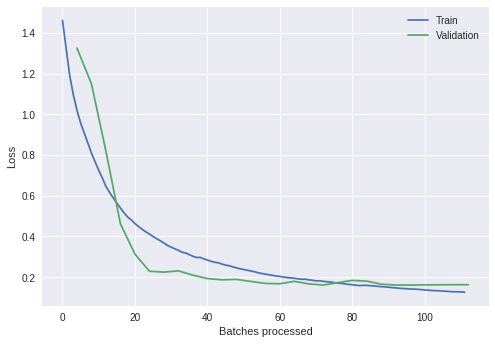

In [0]:
#learn.fit_one_cycle(5, slice(lr)) # can either use slice or no slice
learn.fit_one_cycle(28, lr)

learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-codt')

### sklearn

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [0]:
df_v1 = df[['geocod', 'bound','midx', 'midy', 'midz', 'topx', 'topy', 'topz', 'botx', 'boty', 'botz','length', 'from', 'to']]
label_v1 = df['codt']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_v1, label_v1, test_size = 0.2)

In [0]:
m = RandomForestClassifier(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.99, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
m.score(x_test, y_test)

0.9669117647058824

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(m.predict(x_test), y_test)

array([[115,   0,   2,   2],
       [  0,   2,   0,   1],
       [  0,   0,  31,   0],
       [  3,   1,   0, 115]])

In [0]:
from sklearn.metrics import classification_report

print(classification_report(m.predict(x_test), y_test))

              precision    recall  f1-score   support

           1       0.97      0.97      0.97       119
           2       0.67      0.67      0.67         3
           3       0.94      1.00      0.97        31
           4       0.97      0.97      0.97       119

   micro avg       0.97      0.97      0.97       272
   macro avg       0.89      0.90      0.89       272
weighted avg       0.97      0.97      0.97       272



## predicting gold recovery rate

### deep learning

In [0]:
bs = 256
y_range = torch.tensor([0, 1])


data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .random_split_by_pct(0.2)#split by percent 
                   .label_from_df(cols='aurec', label_cls=FloatList, log=False)
                   .databunch(bs = bs))

In [0]:
learn = tabular_learner(data, layers = [1000,500], emb_drop = 0.05, metrics = [exp_rmspe], ps = [0.5, 0.5], y_range=y_range)


In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(27, 10)
    (1): Embedding(27, 10)
  )
  (emb_drop): Dropout(p=0.05)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


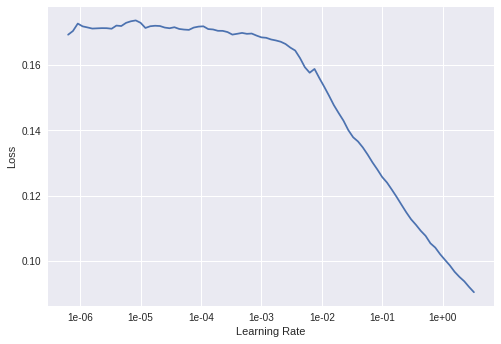

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
learn.save('stage-0-aurec')

In [0]:
learn.load('stage-0-aurec')

Learner(data=TabularDataBunch;

Train: LabelList
y: FloatList (1088 items)
[FloatItem 0.8999999761581421, FloatItem 0.8100000023841858, FloatItem 0.7699999809265137, FloatItem 0.7900000214576721, FloatItem 0.8700000047683716]...
Path: /content/data
x: TabularList (1088 items)
[TabularLine geocod 5; bound 5; midx -1.3907; midy -0.8565; midz 2.3147; topx -1.3904; topy -0.8565; topz 2.3147; botx -1.3910; boty -0.8565; botz 2.3147; length -0.2174; from 0.2805; to 0.1315; , TabularLine geocod 5; bound 5; midx -1.4345; midy -0.7813; midz 0.6602; topx -1.4352; topy -0.7813; topz 0.6602; botx -1.4339; boty -0.7813; botz 0.6602; length 0.8251; from -0.4331; to 0.1315; , TabularLine geocod 5; bound 5; midx -1.4073; midy -0.7872; midz 1.7829; topx -1.4075; topy -0.7872; topz 1.7829; botx -1.4071; boty -0.7872; botz 1.7829; length -0.7387; from 0.9228; to 0.4148; , TabularLine geocod 5; bound 5; midx -1.4181; midy -0.7644; midz 2.7346; topx -1.4192; topy -0.7645; topz 2.7346; botx -1.4170; boty -0

In [0]:
lr = 1e-02
wd = 0.1

epoch,train_loss,valid_loss,exp_rmspe
1,0.130897,0.100778,0.258007
2,0.097700,0.059137,0.233217
3,0.078714,0.057617,0.224742
4,0.058294,0.022876,0.186116
5,0.045512,0.022961,0.183987
6,0.037705,0.024671,0.197728
7,0.032727,0.022468,0.178489
8,0.029219,0.024128,0.196044
9,0.026789,0.021828,0.183793
10,0.024887,0.022162,0.186464


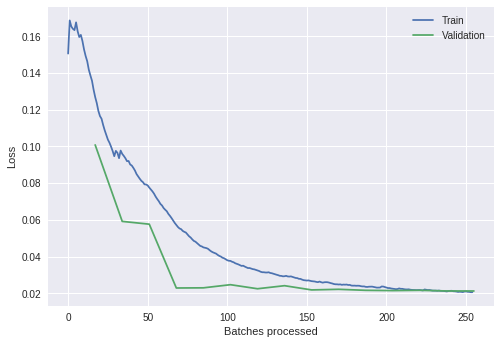

In [0]:
#learn.fit_one_cycle(5, slice(lr)) # can either use slice or no slice
#learn.fit_one_cycle(15, lr, wd = wd)
learn.fit_one_cycle(15, lr)

learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-aurec')

### sklearn

In [0]:
# defining function to evaluate exp_rmspe
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [0]:
df_v1 = df[['geocod', 'bound','midx', 'midy', 'midz', 'topx', 'topy', 'topz', 'botx', 'boty', 'botz','length', 'from', 'to']]
label_v1 = df['aurec']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_v1, label_v1, test_size = 0.2)

In [0]:
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
preds = m.predict(x_test)
exp_rmspe(preds, y_test)

0.1748707590138054

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(preds, y_test)

0.019864753178175567

In [0]:
m.score(x_test, y_test)

-0.029517996103734623

## predicting silver recovery rate

### deep learning


In [0]:
df['agrec']=df['agrec'].replace(-99,0.001, inplace = False)

In [0]:
df['agrec'][131]

0.001

In [0]:
df['nacnc'][209]

0.001

In [0]:
bs = 256
y_range = torch.tensor([0, 1])


data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .random_split_by_pct(0.2)#split by percent 
                   .label_from_df(cols='agrec', label_cls=FloatList, log=False)
                   .databunch(bs = bs))

In [0]:
learn = tabular_learner(data, layers = [1000,500], emb_drop = 0.05, metrics = [exp_rmspe], ps = [0.5, 0.5], y_range=y_range)


In [0]:
learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


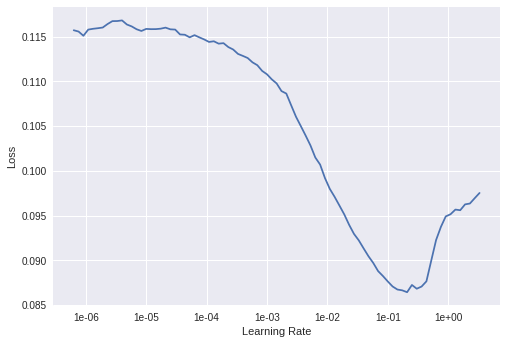

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
learn.save('stage-0-agrec')

In [0]:
learn.load('stage-0-agrec')

Learner(data=TabularDataBunch;

Train: LabelList
y: FloatList (1088 items)
[FloatItem 0.76, FloatItem 0.97, FloatItem 0.56, FloatItem 0.92, FloatItem 0.57]...
Path: /content/data
x: TabularList (1088 items)
[TabularLine geocod 5; bound 5; midx -1.3946; midy -0.8561; midz 2.3096; topx -1.3943; topy -0.8561; topz 2.3096; botx -1.3949; boty -0.8561; botz 2.3096; length -0.2352; from 0.2485; to 0.1000; , TabularLine geocod 5; bound 5; midx -1.4049; midy -0.8215; midz 2.5164; topx -1.4057; topy -0.8214; topz 2.5164; botx -1.4040; boty -0.8215; botz 2.5164; length 1.5296; from 0.4452; to 1.4044; , TabularLine geocod 5; bound 5; midx -1.4053; midy -0.8122; midz 2.5169; topx -1.4055; topy -0.8122; topz 2.5169; botx -1.4050; boty -0.8122; botz 2.5169; length -0.4428; from -0.7348; to -1.0088; , TabularLine geocod 5; bound 5; midx -1.4389; midy -0.7799; midz 0.6636; topx -1.4396; topy -0.7799; topz 0.6636; botx -1.4383; boty -0.7799; botz 0.6636; length 0.8029; from -0.4070; to 0.1000; , Tabular

In [0]:
lr = 1e-02
wd = 0.1

epoch,train_loss,valid_loss,exp_rmspe
1,0.107474,0.107763,0.280480
2,0.101217,0.102077,0.273621
3,0.092207,0.092430,0.260413
4,0.084343,0.074060,0.238365
5,0.078662,0.060205,0.225744
6,0.074897,0.053012,0.224117
7,0.071782,0.050570,0.222533
8,0.069770,0.050812,0.217715
9,0.067782,0.050512,0.214889
10,0.065909,0.050672,0.215019


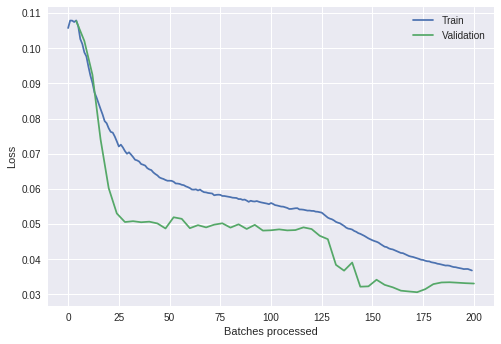

In [0]:
#learn.fit_one_cycle(5, slice(lr)) # can either use slice or no slice
#learn.fit_one_cycle(15, lr, wd = wd)
learn.fit_one_cycle(50, lr)

learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-agrec')

## predicting cyanide use

### dl

In [0]:
# replace -99 with 0
df['nacnc'] = df['nacnc'].replace(-99,0.001, inplace = False)

In [0]:
df['nacnc'][209]



0.001

In [0]:
bs = 256
y_range = torch.tensor([0, 15]) # most of values are between 0 to 12.7, chose 15 to be safe


data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .random_split_by_pct(0.2)#split by percent 
                   .label_from_df(cols='nacnc', label_cls=FloatList, log=False)
                   .databunch(bs = bs))

In [0]:
learn = tabular_learner(data, layers = [1000,500], emb_drop = 0.05, metrics = [exp_rmspe], ps = [0.5, 0.5], y_range=y_range)


In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(27, 10)
    (1): Embedding(27, 10)
  )
  (emb_drop): Dropout(p=0.05)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


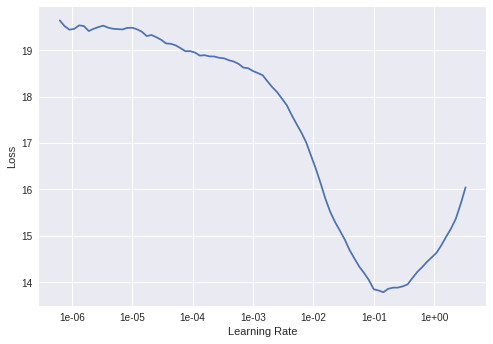

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
learn.save('stage-0-nacnc')

In [0]:
learn.load('stage-0-nacnc')

Learner(data=TabularDataBunch;

Train: LabelList
y: FloatList (1088 items)
[FloatItem 5.92, FloatItem 4.14, FloatItem 6.01, FloatItem 0.8, FloatItem 3.85]...
Path: /content/data
x: TabularList (1088 items)
[TabularLine geocod 5; bound 5; midx -1.3494; midy -0.8216; midz 2.2772; topx -1.3491; topy -0.8216; topz 2.2772; botx -1.3497; boty -0.8216; botz 2.2772; length -0.2347; from 0.3393; to 0.1599; , TabularLine geocod 5; bound 5; midx -1.3593; midy -0.7887; midz 2.4800; topx -1.3602; topy -0.7887; topz 2.4800; botx -1.3585; boty -0.7888; botz 2.4800; length 1.4915; from 0.5707; to 1.6868; , TabularLine geocod 5; bound 5; midx -1.3597; midy -0.7799; midz 2.4806; topx -1.3600; topy -0.7799; topz 2.4806; botx -1.3594; boty -0.7799; botz 2.4806; length -0.4378; from -0.8177; to -1.1380; , TabularLine geocod 5; bound 5; midx -1.3922; midy -0.7493; midz 0.6619; topx -1.3928; topy -0.7493; topz 0.6619; botx -1.3915; boty -0.7492; botz 0.6619; length 0.7807; from -0.4320; to 0.1599; , TabularL

In [0]:
lr = 2e-02
wd = 0.1

epoch,train_loss,valid_loss,exp_rmspe
1,20.710394,16.125023,425.167236
2,18.739710,14.805154,6834.500977
3,17.032171,11.510360,44525.324219
4,15.690928,8.558342,52436.230469
5,14.646087,7.607756,53024.683594
6,13.942897,7.249005,53051.023438
7,13.426142,7.152631,52960.093750
8,12.957146,7.193572,52922.937500
9,12.651632,7.262598,53059.406250
10,12.341368,7.130684,52869.562500


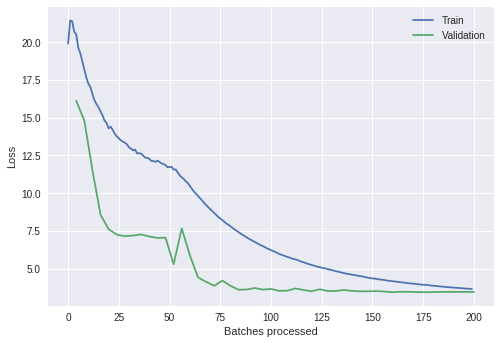

In [0]:
#learn.fit_one_cycle(5, slice(lr)) # can either use slice or no slice
#learn.fit_one_cycle(15, lr, wd = wd)
learn.fit_one_cycle(50, lr)

learn.recorder.plot_losses()

epoch,train_loss,valid_loss,exp_rmspe
1,2.929053,3.974011,13.329939
2,2.962072,4.002772,15.653371
3,2.978585,4.017476,12.931501
4,2.984585,3.989425,12.234688
5,2.995338,3.997396,9.914035
6,3.036026,4.185281,9.985768
7,3.054359,4.146594,17.069748
8,3.063830,4.230459,8.430900
9,3.085938,4.041392,11.306097
10,3.096784,4.058655,13.312190


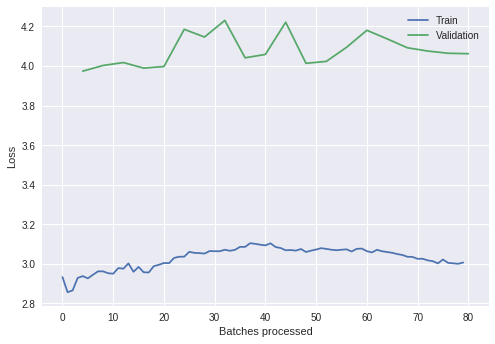

In [0]:
learn.fit_one_cycle(20, lr)

learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-nacnc')

In [0]:
# was 26, val loss was 3.21
#

### sklearn

In [0]:
# defining function to evaluate exp_rmspe
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [0]:
df_v1 = df[['geocod', 'bound','midx', 'midy', 'midz', 'topx', 'topy', 'topz', 'botx', 'boty', 'botz','length', 'from', 'to']]
label_v1 = df['nacnc']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_v1, label_v1, test_size = 0.2)

In [0]:
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(preds, y_test)

13.555636353378976

In [0]:
preds = m.predict(x_test)
exp_rmspe(preds, y_test)

9.094062539827226